Last Update: 2/28/2023

This notebook is for Ablation Study.

This notebook contains Bayesian-WGAN for MNIST, using VCL bound.

### Define Bayesian Generator + Deterministic Discriminator

In [1]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
from copy import deepcopy

In [2]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))
        
        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )
    
    def forward(self, x, x_is_sample, activition_fn, n_particles):
        """
        forward with local reparameterization tricks
        """
        ys = []
        if x_is_sample:
            assert n_particles == len(x)
            for _x in x:
                gamma = _x @ self.weight_loc + self.bias_loc
                delta2 = (_x ** 2) @ (torch.exp(self.log_weight_scale) ** 2) + torch.exp(self.log_bias_scale) ** 2
                y = gamma + torch.randn_like(gamma) * torch.sqrt(delta2 + 1e-6) 
                ys.append(activition_fn(y))
        else:
            for _ in range(n_particles):
                gamma = x @ self.weight_loc + self.bias_loc
                delta2 = (x ** 2) @ (torch.exp(self.log_weight_scale) ** 2) + torch.exp(self.log_bias_scale) ** 2
                y = gamma + torch.randn_like(gamma) * torch.sqrt(delta2 + 1e-6) 
                ys.append(activition_fn(y))
        return ys
    
    def forward_MLE(self, x, activition_fn):
        y = x @ self.weight_loc + self.bias_loc
        return activition_fn(y)

In [3]:
class VCL_Generator(nn.Module):
    def __init__(self, previous_model, random_initialize, init_small_var):
        super().__init__()
        self.hidden1 = BayesLinear(500, 500)
        self.hidden2 = BayesLinear(500, 500)
        self.out_head = BayesLinear(500, 784)

        # intialize distributions as prior distributions
        # define a layer dict
        self.layer_dict = OrderedDict()
        self.layer_dict["hidden1"] = self.hidden1
        self.layer_dict["hidden2"] = self.hidden2
        self.layer_dict["out_head"] = self.out_head

        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                    self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                    if init_small_var:
                        self.layer_dict[key].log_weight_scale.data = torch.zeros_like(self.layer_dict[key].log_weight_scale.data) - 10
                        self.layer_dict[key].log_bias_scale.data = torch.zeros_like(self.layer_dict[key].log_bias_scale.data) - 10
                    else:
                        self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                        self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
            if random_initialize: 
                # the first model's initialization
                # 0 mean and very small variances (do not need to break the symmetricity since the training is based on random samples)
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = torch.randn_like(self.layer_dict[key].weight_loc.data) * 0.1
                    self.layer_dict[key].bias_loc.data = torch.randn_like(self.layer_dict[key].bias_loc.data) * 0.1
                    # initialize to very small value for the first model
                    self.layer_dict[key].log_weight_scale.data = torch.zeros_like(self.layer_dict[key].log_weight_scale.data) - 10
                    self.layer_dict[key].log_bias_scale.data = torch.zeros_like(self.layer_dict[key].log_bias_scale.data) - 10
        
        # also save parameters of the previous model, for the calculation of ELBO
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            previous_locs, previous_logscales = previous_locs.detach().clone(), previous_logscales.detach().clone()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None

    def get_params(self):  
        locs = []
        logscales = []
        for key in self.layer_dict:
            loc, scale = self.layer_dict[key].get_params()
            locs.append(loc)
            logscales.append(scale)
        locs = torch.cat(locs)
        logscales = torch.cat(logscales)
        return locs, logscales

    def generate(self, hiddens, n_particles):
        hiddens = self.hidden1.forward(hiddens, x_is_sample=False, activition_fn=nn.LeakyReLU(0.2), n_particles=n_particles)
        hiddens = self.hidden2.forward(hiddens, x_is_sample=True, activition_fn=nn.LeakyReLU(0.2), n_particles=n_particles)
        x = self.out_head.forward(hiddens, x_is_sample=True, activition_fn=nn.Sigmoid(), n_particles=n_particles)
        return x # a list of x (samples) calculated from z

    def calculate_KL(self):
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        KL = kl_divergence(Normal(loc=locs, scale=torch.exp(logscales)),
                           Normal(loc=self.previous_model_locs, scale=torch.exp(self.previous_model_log_scales))
                          )
        return KL.sum()

    def calculate_gKL(self, lambd):
        locs, logscales = self.get_params()
        Sigma_inv_T_lambda = lambd * torch.clamp(torch.exp(self.previous_model_log_scales)**(-2) - 1, min=1e-3) + 1
        gvclKL = ((locs - self.previous_model_locs) ** 2 * Sigma_inv_T_lambda).sum() + (torch.exp(self.previous_model_log_scales)**(-2) * torch.exp(logscales) ** 2).sum() + 2 * (self.previous_model_log_scales - logscales).sum() - locs.shape[0]
        gvclKL = gvclKL / 2
        return gvclKL.sum()

In [4]:
class Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(50, 500)
        self.linear2 = nn.Linear(500, 500)
    def forward(self, x):
        hidden = nn.ReLU()(self.linear1(x))
        hidden = nn.ReLU()(self.linear2(hidden))
        return hidden

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 500)
        self.linear2 = nn.Linear(500, 500)
        self.linear3 = nn.Linear(500, 500)
        self.linear4 = nn.Linear(500, 1)

    def forward(self, x):
        hidden = nn.ReLU()(self.linear1(x))
        hidden = nn.ReLU()(self.linear2(hidden))
        hidden = nn.ReLU()(self.linear3(hidden))
        f = self.linear4(hidden)
        return f
    def get_params(self):
        param_list = [self.linear1.weight.flatten(), self.linear1.bias.flatten(),
                      self.linear2.weight.flatten(), self.linear2.bias.flatten(),
                      self.linear3.weight.flatten(), self.linear3.bias.flatten(),
                      self.linear4.weight.flatten(), self.linear4.bias.flatten()]
        param_list = torch.cat(param_list)
        return param_list

### Load Dataset

In [6]:
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

def get_MNIST(task_idx, device):
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))
    train_y = torch.tensor([d[1] for d in ds_train])
    train_id = (train_y == task_idx)
    return train_x.to(device)[train_id]

### Train BWGAN

In [7]:
device = "cuda"

In [8]:
def gp(discriminator, real_x, generated_x):
    epsilon = torch.rand(real_x.shape[0], 1, device=real_x.device)
    mixed_images = real_x.detach() * epsilon + generated_x.detach() * (1 - epsilon)
    mixed_images = torch.autograd.Variable(mixed_images, requires_grad=True)
    mixed_scores = discriminator(mixed_images)


    # Take the gradient of the scores with respect to the images
    gradients = torch.autograd.grad(
                                   inputs = mixed_images,
                                   outputs = mixed_scores,
                                   grad_outputs=torch.ones_like(mixed_scores), 
                                   create_graph=True,
                                   retain_graph=True,
                                  )[0]
    gradients = gradients.view(real_x.shape[0], -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

In [9]:
previous_model =  VCL_Generator(previous_model=None, random_initialize=False, init_small_var=False).to(device)
n_epochs = 1000
batch_size = 256
n_samples = 1

generators_dict = {}
head_dict = {}
discriminator_dict = {}

100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


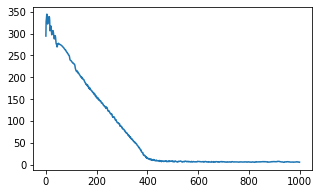

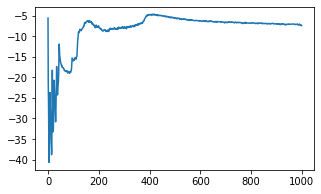

100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]


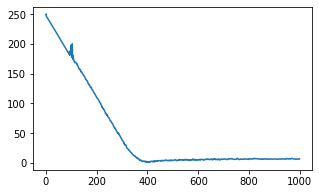

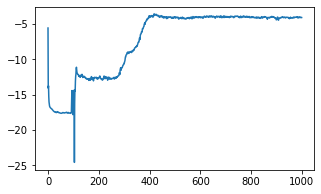

100%|██████████| 1000/1000 [06:02<00:00,  2.75it/s]


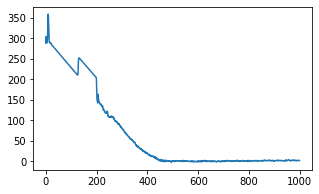

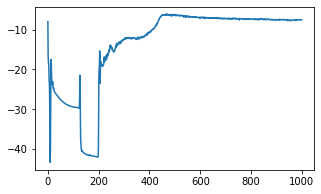

100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


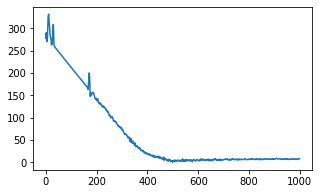

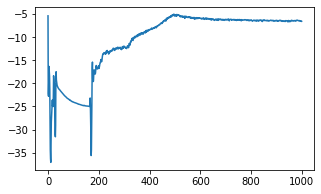

100%|██████████| 1000/1000 [05:49<00:00,  2.87it/s]


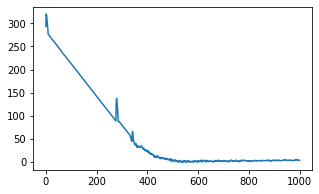

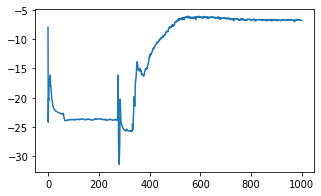

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


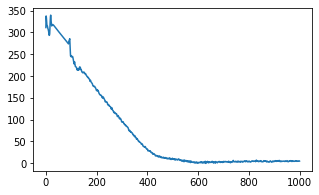

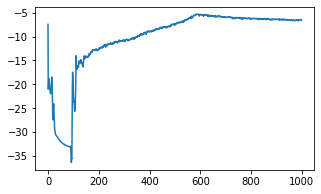

100%|██████████| 1000/1000 [06:00<00:00,  2.78it/s]


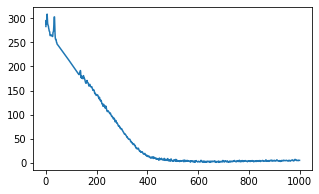

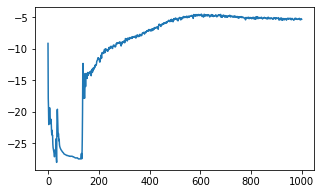

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


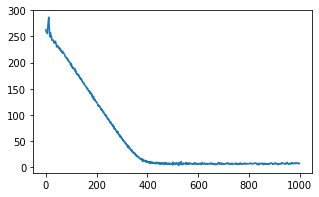

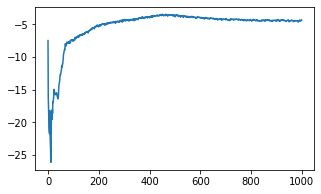

100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


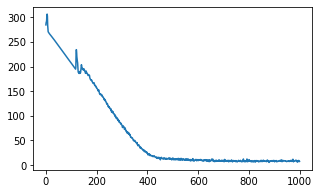

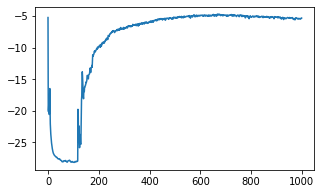

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


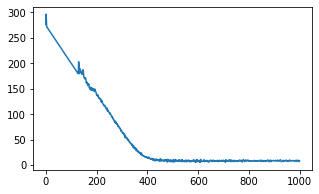

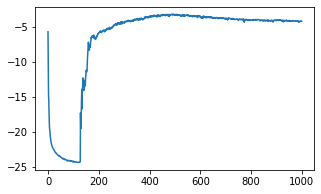

In [10]:
plt.rcParams["figure.figsize"] = [5, 3]
for task in range(10):
    # load data
    train_x = get_MNIST(task, device)

    # define current model
    current_model = VCL_Generator(previous_model=previous_model, random_initialize=False if task != 0 else True, init_small_var=True).to(device)
    current_head = Head().to(device)
    current_opt_generator = torch.optim.Adam(list(current_model.parameters())+list(current_head.parameters()), lr=0.001)
    # define a task specific discrimiator
    # if task == 0:
    discriminator = Discriminator().to(device)
    current_opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    ELBO_gen = []
    Loss_dis = []
    for epoch in tqdm(range(n_epochs)):

        beta = 0.2

        ELBO_batch = []
        Loss_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
        
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size

            # optimize generator by ELBO (using W-Distance)
            current_opt_generator.zero_grad()
            z = torch.randn(batch_size, 50, device=device)
            h = current_head(z)
            generated_x = torch.stack(current_model.generate(h, n_samples)) #n_sample, batch, n_dim
            f = discriminator.forward(generated_x).mean(0).mean()
            # for replay_task in range(task):
            #     z = torch.randn(batch_size, 50, device=device)
            #     generated_x = torch.stack(current_model.generate(z, n_samples, replay_task)) #n_sample, batch, n_dim
            #     f = f + discriminator_dict[replay_task].forward(generated_x).mean(0).mean()
            # f = f / (task+1)
            nelbo= -f + beta * current_model.calculate_KL() / train_x.shape[0]
            nelbo.backward()
            current_opt_generator.step()
            ELBO_batch.append(nelbo.item())

            # optimize discriminator's loss
            current_opt_generator.zero_grad()
            current_opt_discriminator.zero_grad()
            with torch.no_grad():
                z = torch.randn(train_x[batch_idx0: batch_idx1].shape[0], 50, device=device)
                h = current_head(z)
                generated_x = torch.stack(current_model.generate(h, n_samples)).mean(0)


            f1 = discriminator.forward(generated_x)
            f2 = discriminator.forward(train_x[batch_idx0: batch_idx1])
            loss = f1.mean() - f2.mean()
            loss = loss + gp(discriminator, train_x[batch_idx0: batch_idx1], generated_x) 
            # if task!=0:
            #     loss = loss + 0.1*((discriminator.get_params() - old_param_disc)**2).sum()
            loss.backward()
            current_opt_discriminator.step()
            Loss_batch.append(loss.item())

        ELBO_gen.append(np.mean(ELBO_batch))
        Loss_dis.append(np.mean(Loss_batch))
    plt.plot(ELBO_gen)
    plt.show()
    plt.plot(Loss_dis)
    plt.show()

    previous_model = current_model

    generators_dict[task] = current_model
    discriminator_dict[task] = deepcopy(discriminator)
    head_dict[task] = current_head
    old_param_disc = discriminator.get_params().detach().clone()

### Generate digits

In [11]:
def plot_image(model, head):
    with torch.no_grad():
        z = torch.randn(9, 50, device=device)
        h = head(z)
        generated_x = torch.stack(model.generate(h, 1000)).mean(0).reshape(-1, 28, 28).cpu().numpy()
        img = np.zeros([28*3, 28*3])
        for i in range(9):
            img[28 * (i//3): 28 * (i//3)+28, 28 * (i%3): 28 * (i%3)+28] = generated_x[i]
            plt.imshow(img, cmap="gray")
            plt.axis("off")

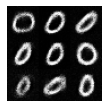

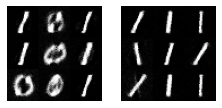

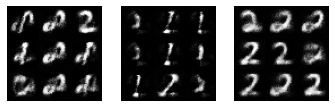

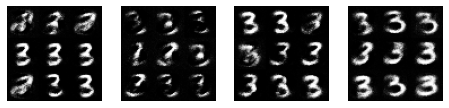

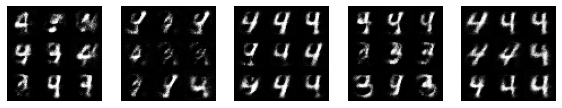

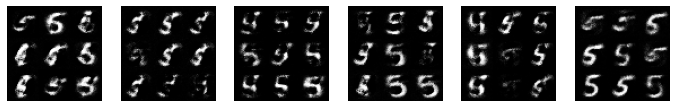

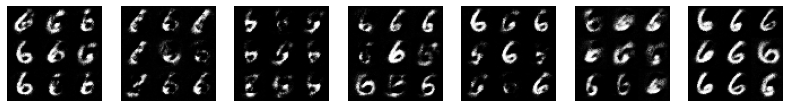

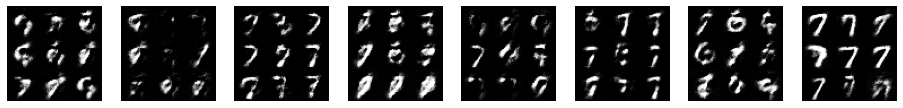

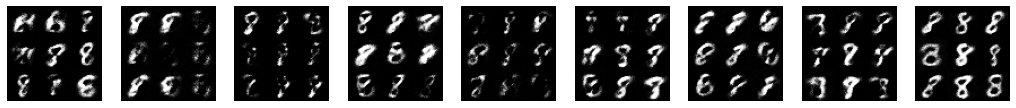

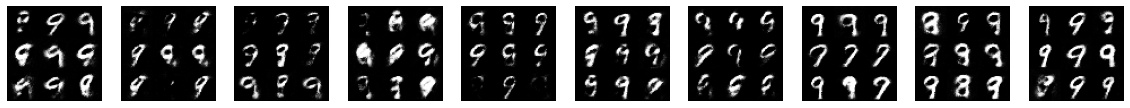

In [12]:
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(10):
    for j in range(i+1):
        plt.subplot(1, 10, j+1)
        plot_image(generators_dict[i], head_dict[j])
    plt.show()

In [13]:
import pickle
with open("/content/drive/MyDrive/Advanced Machine Learning Project/GANs/NBhead_VCL.pkl", "wb") as f:
    pickle.dump([generators_dict, head_dict], f)